<a href="https://colab.research.google.com/github/yuxizhe/HTML-UI-datasets-generate/blob/master/cv%E5%90%8E%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget 'https://drive.google.com/uc?export=download&id=1XRBS9hxK4l1zMQuMNZuefa12r52yKwX2' -O pic.zip
!rm -rf pic
!unzip -q pic.zip

In [0]:
!pip install tf-nightly
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [0]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

#获取图片内矩形函数

def cv_get_block(location):
  img = cv2.imread(location)
  # img resize to 700
  img = cv2.resize(img, (700,int(700/img.shape[1]*img.shape[0])), interpolation=cv2.INTER_AREA)
  #cv2_imshow(img)
  # 转为灰度
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # 边缘检测
  binary = cv2.Canny(gray,50,100)
  #ret,binary = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

  #cv2_imshow(binary)

  #检测轮廓
  # RETR_EXTERNAL  表示只检测最外层轮廓
  #print(cv2.MinAreaRect2(binary))
  contours, hier = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  trueBoxes = []
  # 裁剪出的图片
  croppedImage = []
  for c in contours:  #遍历轮廓
      rect = cv2.minAreaRect(c)  #生成最小外接矩形
      # cv2_imshow(rect)
      box_ = cv2.boxPoints(rect)
      h = abs(box_[3, 1] - box_[1, 1])
      w = abs(box_[3, 0] - box_[1, 0])
      # print("宽，高",w,h)
      #只保留需要的轮廓
      if (h > 500 or w > 600):
          continue
      if (h < 20 or w < 60):
          continue
   
      # 这个返回坐标点顺序是随机的
      box = cv2.boxPoints(rect)  # 计算最小面积矩形的坐标
      box = np.int0(box)  # 将坐标规范化为整数
      trueBoxes.append(box)
      # 取出图片
      # image[y:y+h, x:x+w]
      print(h,w)
      print(box)
      # 因为boxPoints返回坐标点顺序是随机的，无法使用顺序计算
      #cropped = img[box[2][1]-5 : box[0][1]+5, box[2][0]-5 : box[0][0]+5 ]
      cropped = img[
                    min(box[2][1],box[0][1])-5:max(box[2][1],box[0][1])+5,
                    min(box[2][0],box[0][0])-5:max(box[2][0],box[0][0])+5]
      cv2_imshow(cropped)

      cropped = resize_image(cropped)

      croppedImage.append(cropped)
      # 绘制矩形
      cv2.drawContours(img, [box], 0, (255, 0, 255), 1)
  #cv2_imshow(img)

  print("矩形元素个数", len(trueBoxes))
  # 输出 array 而不是list 
  # 'Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (224, 224, 3))
  # 因为 ImageDataGenerator.flow 输入为 NumpyArray
  return np.array(croppedImage), np.array(trueBoxes), img

In [0]:
# 图像归一为 224 224
import os
import cv2
import glob
import numpy as np

min_side = 224

def resize_image(img):
    size = img.shape
    h, w = size[0], size[1]
    #长边缩放为min_side 
    scale = max(w, h) / float(min_side)
    new_w, new_h = int(w/scale), int(h/scale)
    resize_img = cv2.resize(img, (new_w, new_h))
    # 填充至min_side * min_side
    if new_w % 2 != 0 and new_h % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
    elif new_h % 2 != 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    elif new_h % 2 == 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    else:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
    pad_img = cv2.copyMakeBorder(resize_img, int(top), int(bottom), int(left), int(right), cv2.BORDER_CONSTANT, value=[255,255,255]) #从图像边界向上,下,左,右扩的像素数目
    #print pad_img.shape
    #cv2.imwrite("after-" + os.path.basename(filename), pad_img)
    return pad_img


In [0]:
# 输出分类结果
import matplotlib.pyplot as plt
def result_show(image_batch, predicted_name):
  plt.figure(figsize=(15,15))
  plt.subplots_adjust(hspace=0.5)
  for n in range(len(predicted_name)):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_name[n].title())
    plt.axis('off')

In [0]:
# 在图片上显示结果
# 通过ImageDataGenerator.flow 后 顺序会变化
def result_show_in_image(img, boxes, predicted_name):
  for index in range(len(boxes)):
    box = boxes[index]
    name = predicted_name[index]
    cv2.putText(img, name, (min(box[2][0],box[0][0]) + 10, max(box[2][1],box[0][1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (225,0,225), 1)
  cv2_imshow(img)

In [0]:
# 显示 ImageDataGenerator 处理后的图形
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(len(image_batch)):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n].squeeze())
      # plt.title(CLASS_NAMES[int(label_batch[n])])
      plt.axis('off')

In [0]:
# 复制训练好的模型
!cp -rp /content/drive/My\ Drive/Fast.io/ygd.imfast.io/model/1589361295 /content/model/

In [0]:
# 加载模型
html_model = tf.keras.models.load_model('/content/model/')

In [0]:
# create a data generator
datagen = ImageDataGenerator(rescale=(1/255))

29.0 104.0
[[114 567]
 [114 538]
 [218 538]
 [218 567]]


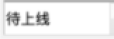

36.0 128.0
[[111 568]
 [111 532]
 [239 532]
 [239 568]]


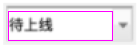

43.0 347.99994
[[130 491]
 [130 448]
 [478 448]
 [478 491]]


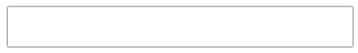

43.0 117.0
[[291 437]
 [291 394]
 [408 394]
 [408 437]]


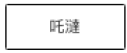

47.0 120.0
[[291 439]
 [291 392]
 [411 392]
 [411 439]]


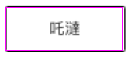

52.0 186.0
[[425 441]
 [425 389]
 [611 389]
 [611 441]]


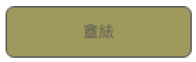

37.0 110.0
[[156 376]
 [156 339]
 [266 339]
 [266 376]]


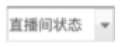

48.0 284.99994
[[130 322]
 [130 274]
 [415 274]
 [415 322]]


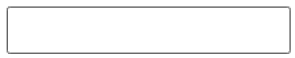

35.0 177.0
[[108 261]
 [108 226]
 [285 226]
 [285 261]]


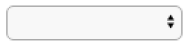

49.0 135.99995
[[190 218]
 [190 169]
 [326 169]
 [326 218]]


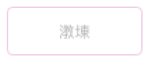

30.0 268.0
[[131 163]
 [131 133]
 [399 133]
 [399 163]]


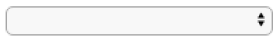

37.0 281.0
[[133  93]
 [133  56]
 [414  56]
 [414  93]]


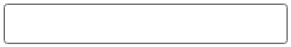

41.0 285.0
[[131  95]
 [131  54]
 [416  54]
 [416  95]]


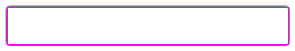

30.0 324.0
[[457  38]
 [133  38]
 [133   8]
 [457   8]]


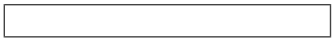

33.999992 327.99994
[[130  39]
 [130   6]
 [458   6]
 [458  39]]


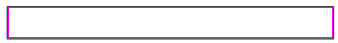

矩形元素个数 15
['Input' 'Button' 'Button' 'Button' 'Input' 'Input' 'Input' 'Select'
 'Select' 'Select' 'Button' 'Select' 'Select' 'Input' 'Select']


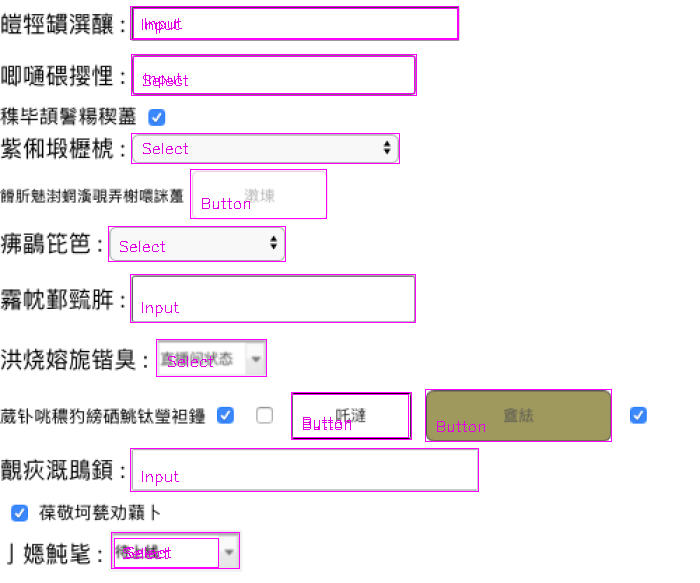

In [120]:
# 从图片CV获取元素
images,boxes,img = cv_get_block('/content/pic/train/2.png')

# 矩形元素 通过ImageDataGenerator 图像进一步处理
# 需要注意的是，通过flow输出的数据是乱序的，并不会严格安装输入的顺序，所以对应关系要存储在label中
input_data = datagen.flow(images, boxes)
image_batch, boxes_batch = next(input_data)
# 预测元素
predicted_batch = html_model.predict(image_batch)

# 结果归一
predicted_id = np.argmax(predicted_batch, axis=-1)

class_name = np.array(['Input', 'Select', 'Button'])
# 结果对应上名字
predicted_name = class_name[predicted_id]
print(predicted_name)
# 图示结果
#result_show(image_batch, predicted_name)

result_show_in_image(img, boxes_batch, predicted_name)